In [1]:
from pathlib import Path
import pandas as pd
from idf_analysis.idf_class import IntensityDurationFrequencyAnalyse
from idf_analysis.definitions import *
from idf_analysis import __version__
print(f'{__version__=}')

__version__='0.2.9'


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Intensity Duration Frequency Analyse

## Parameter

**series_kind**:

`SERIES.PARTIAL` = Partielle Serie (partial duration series, PDS) (peak over threshold, POT)

`SERIES.ANNUAL` = Jährliche Serie (annual maximum series, AMS)

**worksheet**:

`METHOD.KOSTRA`:
- DWA-A 531
- KOSTRA - recommented
- Parameter formula change at 60 min and 12 h

`METHOD.CONVECTIVE_ADVECTIVE`:
- DWA-A 531
- Unterscheidung in überwiegend konvektiv und advektiv verursachte Starkregen
- Parameter formula change at 3 h and 24 h

`METHOD.ATV`:
- ATV-A 121
- Parameter formula change at 3 h and 48 h

**extended_durations** = Includes the durations steps `[0.75d, 1d, 2d, 3d, 4d, 5d, 6d]` in the analysis (d=days)

Default duration steps `[5m, 10m, 15m, 20m, 30m, 45m, 60m, 1.5h, 3h, 4.5h, 6h, 7.5h, 10h, 12h]`

In [3]:
idf = IntensityDurationFrequencyAnalyse(series_kind=SERIES.PARTIAL, worksheet=METHOD.KOSTRA, extended_durations=True)

I used the rain-time-series from ehyd.gv.at with the ID 112086 (Graz-Andritz) [created with the ehyd-tools package](https://github.com/MarkusPic/ehyd_tools/blob/main/example/example_python_api.ipynb). 

In [4]:
data = pd.read_parquet('ehyd_112086.parquet').squeeze('columns')

Get a look at the time-series

In [5]:
data.head()

datetime
2007-09-17 13:56:00    0.0
2007-09-17 13:57:00    0.0
2007-09-17 13:58:00    0.0
2007-09-17 13:59:00    0.0
2007-09-17 14:00:00    0.0
Name: N-Minutensummen-112086, dtype: float64

In [6]:
data.tail()

datetime
2019-12-31 23:56:00    0.0
2019-12-31 23:57:00    0.0
2019-12-31 23:58:00    0.0
2019-12-31 23:59:00    0.0
2020-01-01 00:00:00    NaN
Name: N-Minutensummen-112086, dtype: float64

Set the time-series to be used for the calculation of the IDF parameters

In [7]:
idf.set_series(data)

define a working directory to save some plots and interim results

In [8]:
output_directory = Path('ehyd_112086_idf_data')

create a plot for the interim parameters of the partial series.

Calculating Parameters u and w:   0%|          | 0/21 [00:00<?, ?it/s]

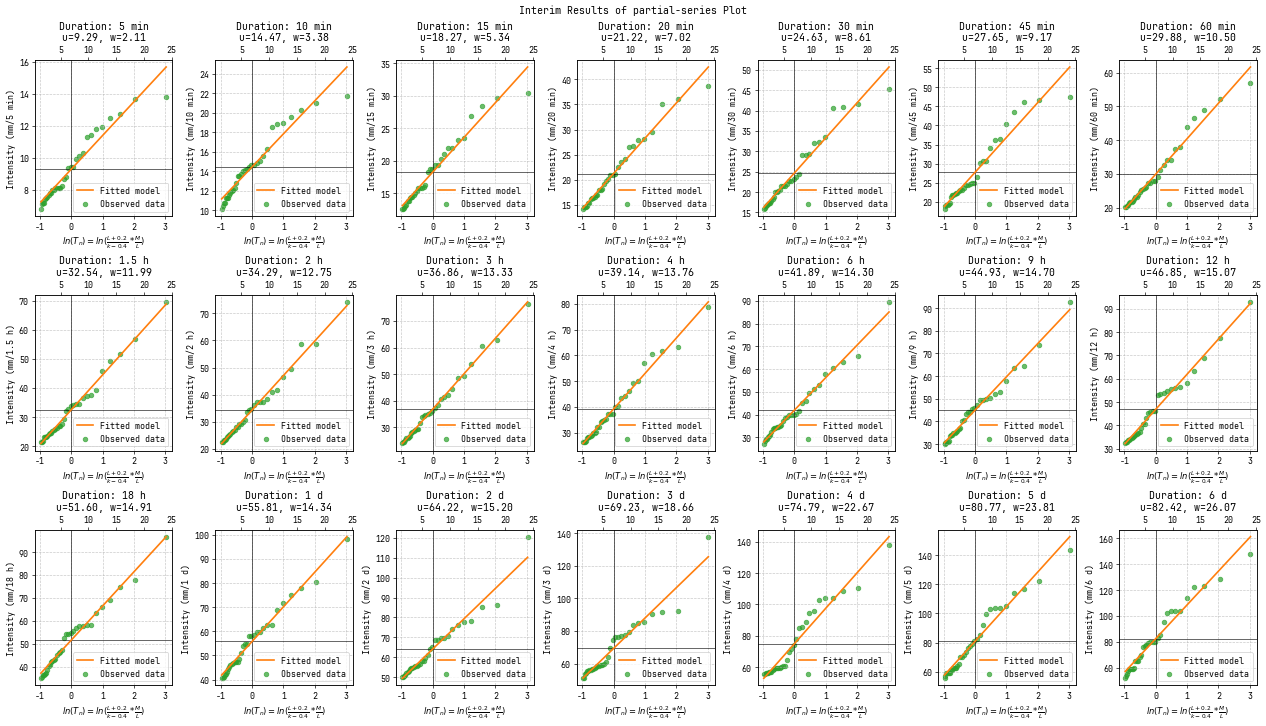

In [9]:
fig = idf.parameters._interims.plot_series(ncols=7)
fig.set_size_inches(21,12)
fig.set_dpi(60)

Intermediate results are created for each new calculation, which are only dependent on the selected series `series_kind` and the specified/required duration steps. This process takes a few seconds.
In addition, these intermediate results contain the parameters required to calculate the rainfall height.
The calculation methods and formula-change-durations according to the selected `worksheet` are already taken into account here.

In [10]:
idf.write_parameters(output_directory / 'idf_parameters.yaml')

To save time, it is possible to save the parameters temporarily and when the script is called up again, these parameters are no longer calculated but read from the file.

In [11]:
idf.auto_save_parameters(output_directory / 'idf_parameters.yaml')

These interim results can be called up with:

In [12]:
idf.parameters.pprint()

{'durations': [5.0,
               10.0,
               15.0,
               20.0,
               30.0,
               45.0,
               60.0,
               90.0,
               120.0,
               180.0,
               240.0,
               360.0,
               540.0,
               720.0,
               1080.0,
               1440.0,
               2880.0,
               4320.0,
               5760.0,
               7200.0,
               8640.0],
 'parameters_final': {0: {'u': HyperbolicAuto(38.04, 16.10),
                          'w': DoubleLogNormAuto(0.16, 0.55)},
                      60: {'u': DoubleLogNormAuto(2.65, 0.18),
                           'w': DoubleLogNormAuto(1.88, 0.13)},
                      720: {'u': Linear(), 'w': Linear()}},
 'parameters_series': {'u': [9.2852,
                             14.4656,
                             18.2676,
                             21.223,
                             24.6312,
                             27.6473,
  

In [13]:
idf.parameters

plot the interim results for the final parameters of the function to calculate the rainfall height depending on duration and return periods.

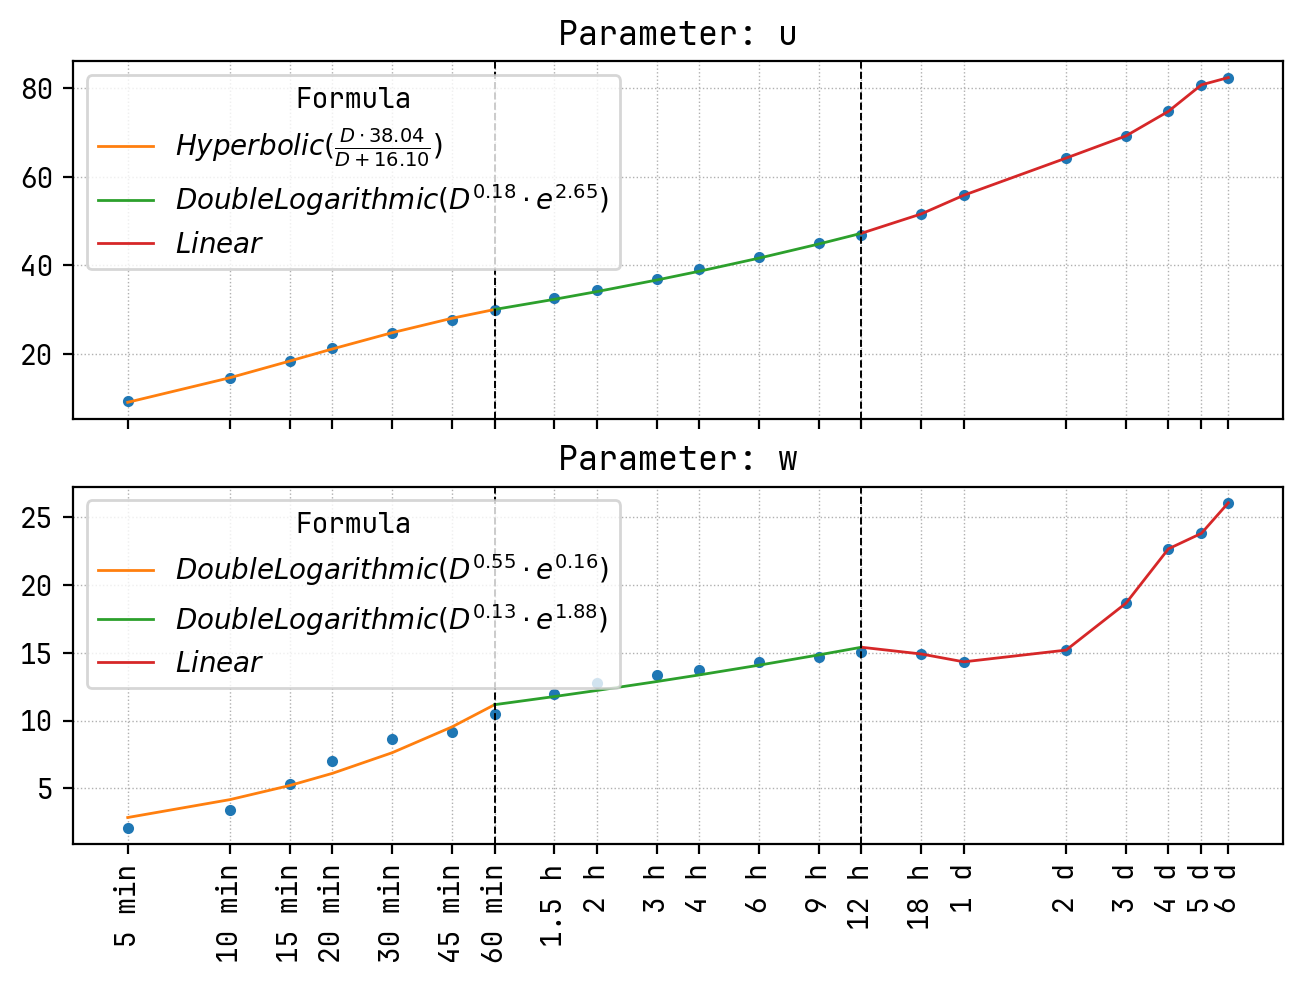

In [14]:
fig = idf.parameters.interim_plot_parameters()

test also other formulas for the IDF function (According to the older guideline ATV-A 121 (till 2012))

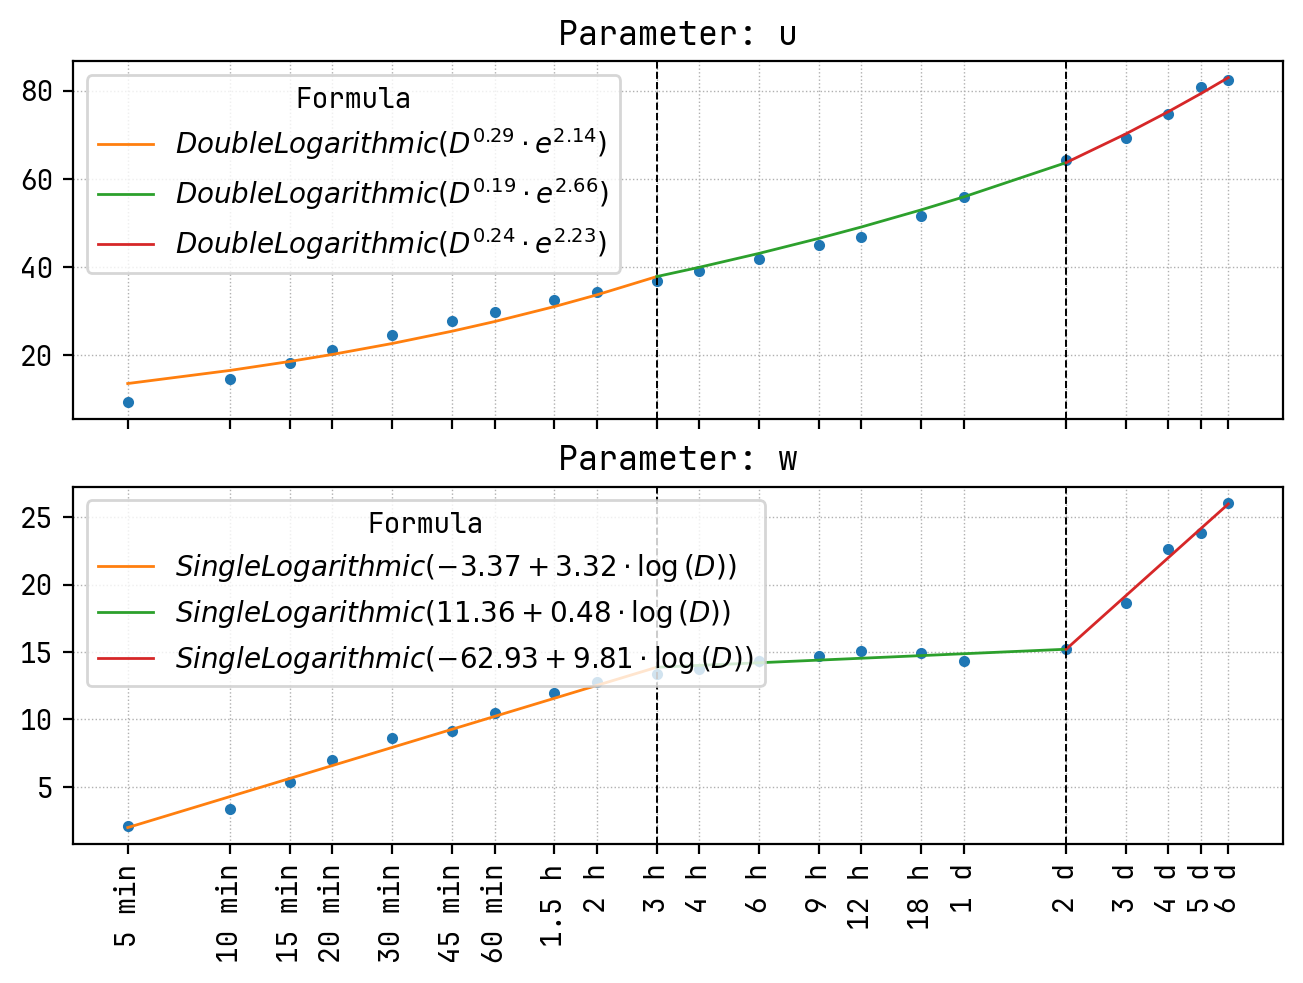

In [15]:
idf.parameters.set_parameter_approaches_from_worksheet(METHOD.ATV)
fig = idf.parameters.interim_plot_parameters()

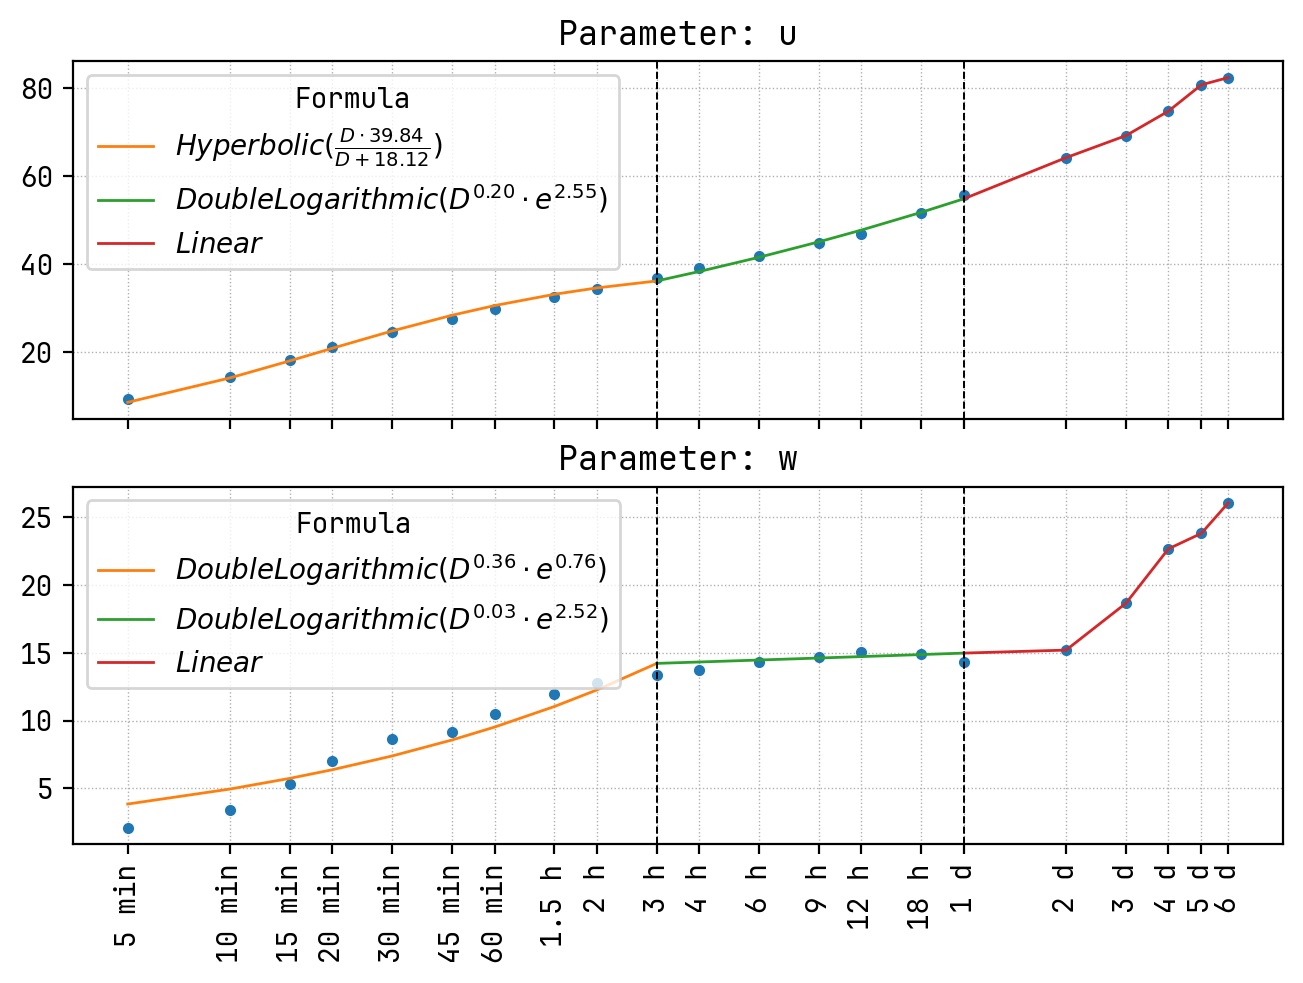

In [16]:
idf.parameters.set_parameter_approaches_from_worksheet(METHOD.CONVECTIVE_ADVECTIVE)
fig = idf.parameters.interim_plot_parameters()

## Calculations

In [17]:
idf.depth_of_rainfall(duration=15, return_period=1)

18.042501067209535

In [18]:
print('Resulting rainfall height h_N(T_n={t:0.1f}a, D={d:0.1f}min) = {h:0.2f} mm'
      ''.format(t=1, d=15, h=idf.depth_of_rainfall(15, 1)))

Resulting rainfall height h_N(T_n=1.0a, D=15.0min) = 18.04 mm


In [19]:
idf.rain_flow_rate(duration=15, return_period=1)

200.47223408010595

In [20]:
print('Resulting rainfall flow rate r_N(T_n={t:0.1f}a, D={d:0.1f}min) = {r:0.2f} L/(s*ha)'
      ''.format(t=1, d=15, r=idf.rain_flow_rate(15, 1)))

Resulting rainfall flow rate r_N(T_n=1.0a, D=15.0min) = 200.47 L/(s*ha)


In [21]:
idf.r_720_1()

11.05568516972672

In [22]:
idf.get_return_period(height_of_rainfall=10, duration=15)

0.24641175384609787

In [23]:
idf.get_duration(height_of_rainfall=10, return_period=1)

6.073216157634265

In [24]:
idf.result_table().round(2)

,1,2,3,5,10,20,25,30,50,75,100
5,8.61,11.28,12.84,14.80,17.47,20.13,20.99,21.69,23.66,25.22,26.32
10,14.17,17.60,19.61,22.14,25.57,29.00,30.11,31.01,33.54,35.55,36.97
15,18.04,22.02,24.35,27.28,31.26,35.24,36.52,37.57,40.50,42.83,44.48
20,20.90,25.32,27.91,31.17,35.59,40.01,41.43,42.59,45.85,48.44,50.27
30,24.84,29.96,32.96,36.74,41.86,46.99,48.64,49.99,53.76,56.76,58.89
45,28.40,34.35,37.82,42.20,48.15,54.09,56.00,57.56,61.94,65.42,67.89
60,30.60,37.20,41.06,45.93,52.53,59.13,61.25,62.99,67.85,71.72,74.46
90,33.16,40.82,45.30,50.94,58.59,66.24,68.71,70.72,76.36,80.84,84.01
120,34.61,43.12,48.09,54.35,62.86,71.36,74.09,76.33,82.59,87.57,91.10
180,36.20,46.06,51.82,59.09,68.94,78.80,81.97,84.57,91.83,97.60,101.69


In [25]:
idf.result_table(add_names=True).round(2)

return period (a),1,2,3,5,10,20,25,30,50,75,100
frequency (1/a),1.000,0.500,0.333,0.200,0.100,0.050,0.040,0.033,0.020,0.013,0.010
duration (min),,,,,,,,,,,
5,8.61,11.28,12.84,14.80,17.47,20.13,20.99,21.69,23.66,25.22,26.32
10,14.17,17.60,19.61,22.14,25.57,29.00,30.11,31.01,33.54,35.55,36.97
15,18.04,22.02,24.35,27.28,31.26,35.24,36.52,37.57,40.50,42.83,44.48
20,20.90,25.32,27.91,31.17,35.59,40.01,41.43,42.59,45.85,48.44,50.27
30,24.84,29.96,32.96,36.74,41.86,46.99,48.64,49.99,53.76,56.76,58.89
45,28.40,34.35,37.82,42.20,48.15,54.09,56.00,57.56,61.94,65.42,67.89
60,30.60,37.20,41.06,45.93,52.53,59.13,61.25,62.99,67.85,71.72,74.46
90,33.16,40.82,45.30,50.94,58.59,66.24,68.71,70.72,76.36,80.84,84.01


To save the table as a csv:

In [26]:
idf.result_table(add_names=True).round(2).to_csv(output_directory / 'idf_table_UNIX.csv', sep=',', decimal='.', float_format='%0.2f')

In [27]:
print(idf.result_table(add_names=True).round(2).to_string())

return period (a)    1       2       3       5       10      20      25      30      50      75      100
frequency (1/a)    1.000   0.500   0.333   0.200   0.100   0.050   0.040   0.033   0.020   0.013   0.010
duration (min)                                                                                          
5                   8.61   11.28   12.84   14.80   17.47   20.13   20.99   21.69   23.66   25.22   26.32
10                 14.17   17.60   19.61   22.14   25.57   29.00   30.11   31.01   33.54   35.55   36.97
15                 18.04   22.02   24.35   27.28   31.26   35.24   36.52   37.57   40.50   42.83   44.48
20                 20.90   25.32   27.91   31.17   35.59   40.01   41.43   42.59   45.85   48.44   50.27
30                 24.84   29.96   32.96   36.74   41.86   46.99   48.64   49.99   53.76   56.76   58.89
45                 28.40   34.35   37.82   42.20   48.15   54.09   56.00   57.56   61.94   65.42   67.89
60                 30.60   37.20   41.06   45.93   52.5

To create a color plot of the IDF curves:

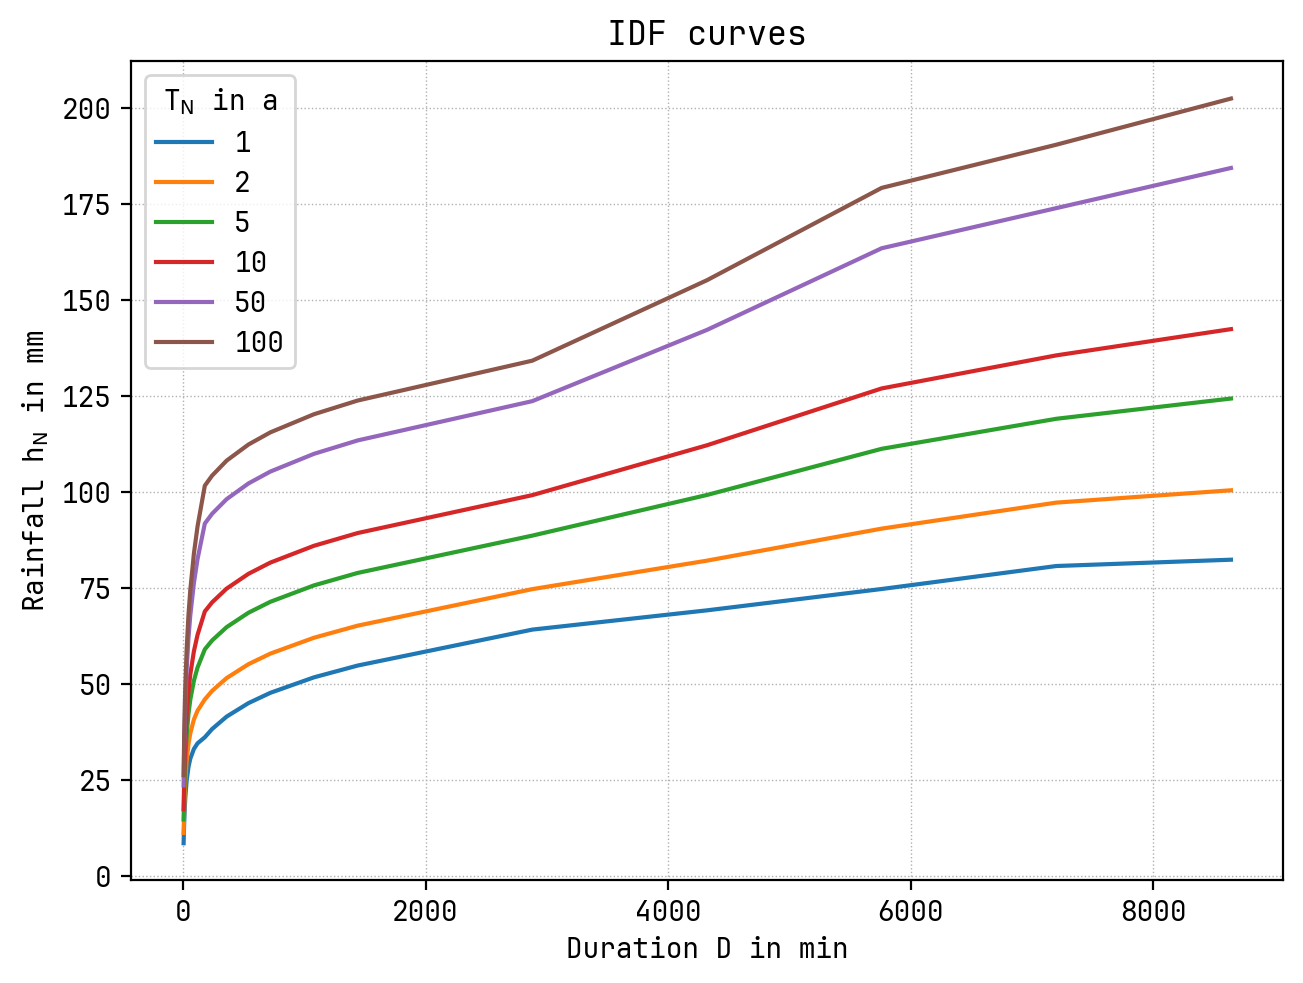

In [28]:
fig, ax = idf.curve_figure(color=True, add_interim=False)

To create a black/white plot of the IDF curves:

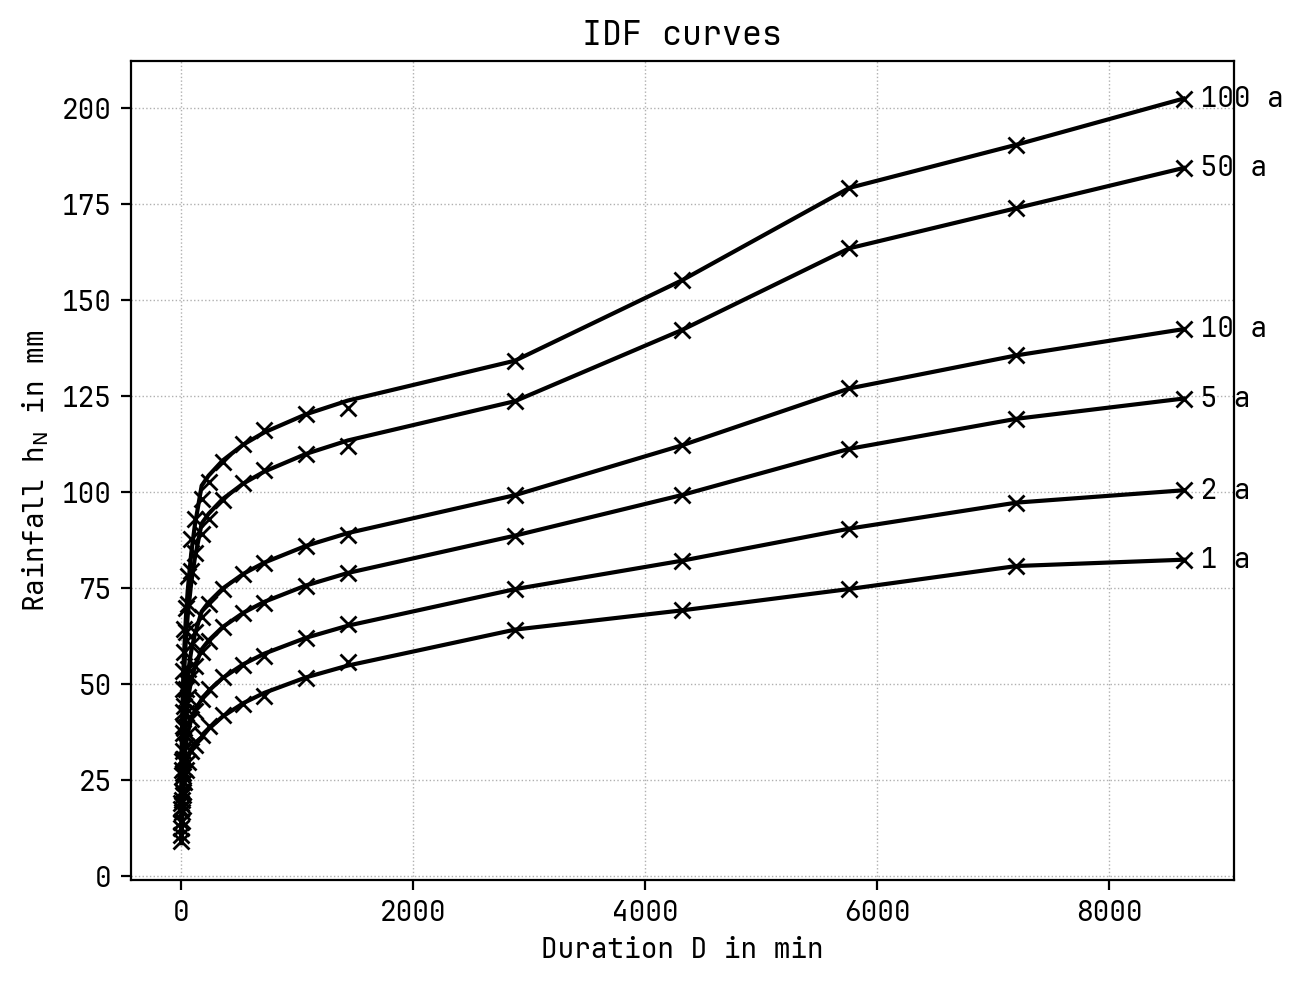

In [29]:
fig, ax = idf.curve_figure(color=False, add_interim=True)

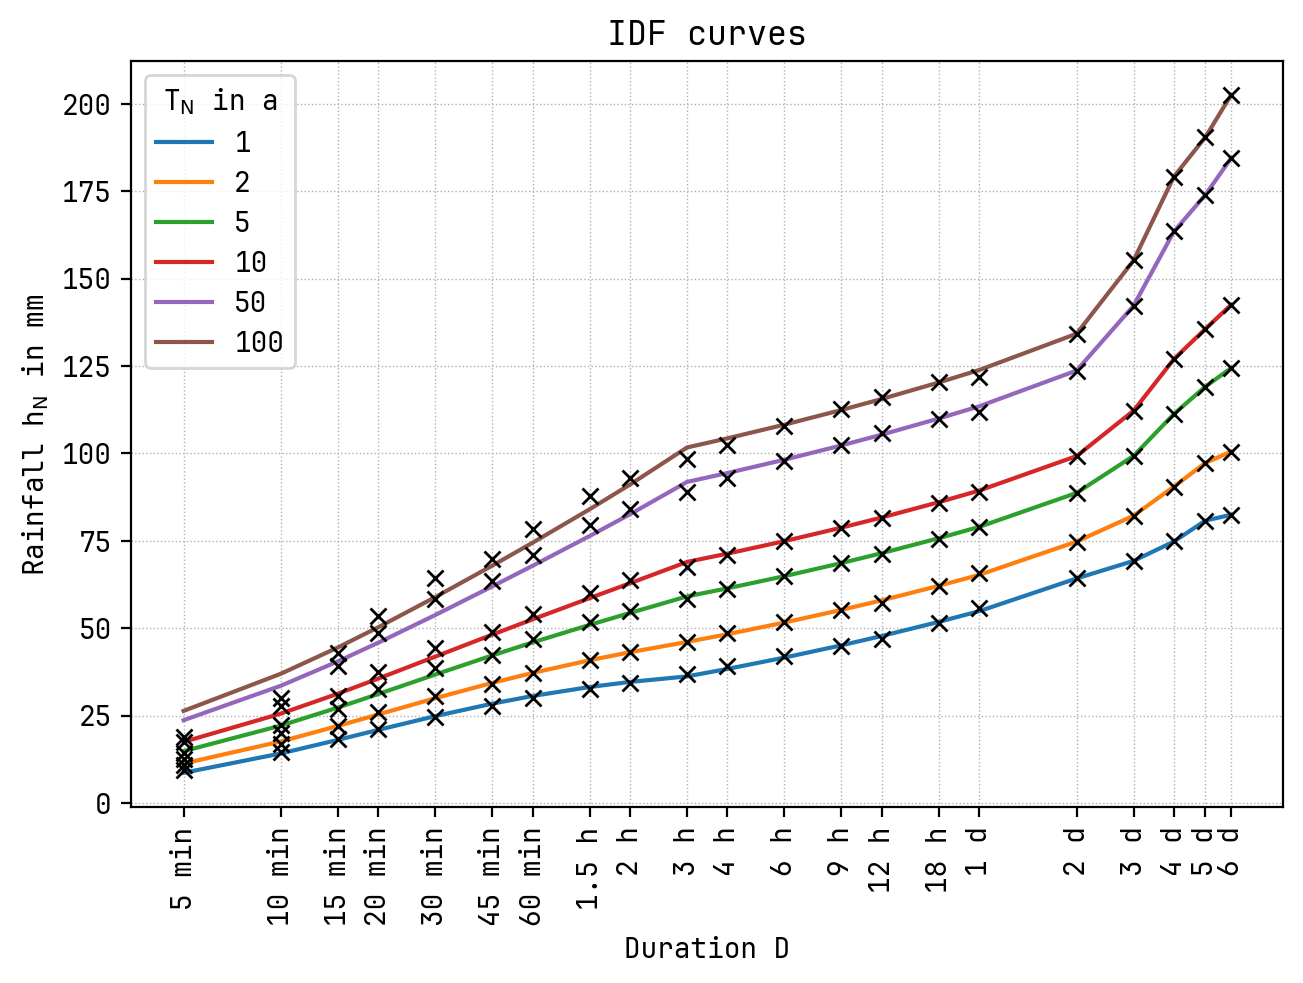

In [30]:
fig, ax = idf.curve_figure(color=True, add_interim=True, logx=True, duration_steps_ticks=True)